# 2017 Tax Assesed Home Value Prediction Models

# Group 4
* Justin Evans
* Yvette Ibarra

# Project Overview:
This project has been tasked with collecting, cleaning and analyzing Zillow data from 2017 in order to improve a previous prediction model that was designed to predict the Tax Assessed Home Value for Single Family Properties based on available realestate data.

# Goals: 
* Predict property tax assessed values of Single Family Properties
* Outperform existing logerror model
* Recommend improvements for a more accurate model
* Define relevant fips codes for our data

# Reproduction of this Data:
* Can be accomplished using a local ```env.py``` containing ```user, password, host``` information for access to the Codeup SQL database server.
* All other step by step instructions can be found by reading the below Jupyter Notebook files located in my [proj-2_zillow](https://github.com/QMCBT-JustinEvans/project-2_zillow.git) github repository.
    * 01_wrangle
    * 02_explore
    * 03_model

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Decision Tree and Model Evaluation Imports
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import classification_report 

# import preprocessing
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer

# Cluster
from sklearn.cluster import KMeans

# assists with processor speed
#import matplotlib as mpl
#mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt
# Increases Display Resolution for Graphs 
# Only works inside notebook
%matplotlib inline 

# import Environment and Helper Files
from env import user, password, host
import QMCBT_00_quicktips as qt
#import QMCBT_01_acquire as acquire
#import QMCBT_02_prepare as prepare
#import QMCBT_03_explore as explore
#import QMCBT_04_modeling as model
#import QMCBT_05_evaluate as evaluate
import QMCBT_explore_evaluate as ee
import wrangle as w

# set constants
α = 0.05
alpha = 0.05
np.random.seed(123)
#random_state=123

# Turns off warnings
import warnings
warnings.filterwarnings("ignore")

# Left Align Tables in Jupyter Notebook
from IPython.core.display import HTML
table_css = 'table {align:left;display:block}'
HTML('<style>{}</style>'.format(table_css))

In [2]:
# allows import reload without needing to clear kernel and rerun
# reload(packagename) 
from importlib import reload

# This code refreshes all of my helper files (w/o the need to stop the kernel)
reload(qt)
#reload(acquire)
#reload(prepare)
#reload(explore)
#reload(model)
#reload(evaluate)
reload(ee)
reload(w)

<module 'wrangle' from '/Users/qmcbt/codeup-data-science/project_zillow_team/wrangle.py'>

<div class="alert alert-danger">

    
## Data Acquisition: 
Data is collected from the codeup cloud database with an appropriate SQL query

# Acquire

<div class="alert alert-success">

* ```zillow``` data from Codeup SQL database was used for this project.
* The data was initially pulled on 15-NOV-2022.
* The initial DataFrame contained 52,441 records with 69 features  
    (69 columns and 52,441 rows) before cleaning & preparation.
* Each row represents a Single Family Property record with a Tax Asessment date within 2017.
* Each column represents a feature provided by Zillow or an informational element about the Property.
</div>

In [3]:
df = w.get_zillow_data()

In [4]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,52309,52310,52311,52312,52313,52314,52315,52316,52317,52318
id,1727539,1387261,11677,2288172,781532,870991,1246926,1639362,249412,43675,...,1810799,2747021,80446,1635173,1373391,2274245,673515,2968375,1843709,1187175
parcelid,14297519,17052889,14186244,12177905,12095076,12069064,12790562,11104527,13944538,17110996,...,11978003,11318911,12055795,12892446,10722691,12412492,11000655,17239384,12773139,12826780
airconditioningtypeid,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,13.0,NaN,...,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bulding_class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heat_systems,NaN,NaN,NaN,Central,Central,NaN,Central,Central,NaN,NaN,...,Central,Floor/Wall,NaN,Central,Central,Central,Central,NaN,Central,Central
land_use,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,...,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential,Single Family Residential
story,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

<div class="alert alert-success">

**Prepare Actions:**

* **Whitespace:** Removed 52,441 Whitespace characters.
* **REFORMAT:** Reformatted 13 columns containing 596,382 NaN entries to 0.
* **CONVERT dtypes:** Convert dtypes to accurately reflect data contained within Feature.
* **FEATURE ENGINEER:** Use Yearbuilt to create Age Feature, Drop yearbuilt for redundancy; create Feature to show ratio of Bathrooms to Bedrooms.
* **fips CONVERSION:** Use fips master list to convert fips to county and state, Drop state for redundancy.
* **PIVOT:** Pivot the resulting county column from fips conversion to 3 catagorical features. 
* **DROP:** Dropped 27 Columns unecessary to data prediction (ie.. index and redundant features).
* **REPLACE:** Replaced conditional values in 2 columns to transform into categorical features.
* **RENAME:** Columns for Human readability.    
* **REORDER:** Rearange order of columns for human readability.   
* **DROP 2:** Drop Location Reference Columns unsuitable for use with ML without categorical translation.
* **CACHE:** Write cleaned DataFrame into a new csv file ('zillow_2017_cleaned.csv').  
* **ENCODED:** No encoding required.
* **MELT:** No melts needed.
</div>

<div class="alert alert-info">

    
# Summary of Data Cleansing
* Cleaning the data resulted in less than 6% overall record loss
</div>

<div class="alert alert-warning">
    
* <b>DROP NaN COLUMNS:</b> 39 features each containing over 30% NaN were dropped; <b>resulting in no record loss</b>.
  
* <b>DROP NaN ROWS:</b> 1,768 records containing NaN across 13 features were dropped; <b>resulting in only 3% record loss</b>.

* <b>OUTLIERS:</b> Aproximately 3,000 outliers were filtered out in an attempt to more accurately align with realistic expectations of a Single Family Residence; <b>resulting in less than a 6% decrease in overall records</b>.

* <b>IMPUTE:</b> No data was imputed</div>

<div class="alert alert-danger">
    
    
## Data Prep:
* Column data types are appropriate for the data they contain
* Missing values are investigated and handled
* Outliers are investigated and handled
    * BED and Bath >0 <8  
    * SQFT >400 <10_000  
    * Tax Value < 2 million  

In [5]:
df = w.zillow_prep(df)

In [6]:
df.head(0).T

""
parcelid
bedrooms
bathrooms
calculatedbathnbr
fullbathcnt
age
yearbuilt
has_basement
has_deck
has_fireplace


In [7]:
df.isnull().sum().sort_values()

parcelid                  0
orange_county             0
ventura_county            0
longitude                 0
latitude                  0
zipcode                   0
regionidcounty            0
la_county                 0
rawcensustractandblock    0
sqft                      0
lot_sqft                  0
tax_value_bldg            0
tax_value                 0
tax_value_land            0
taxamount                 0
censustractandblock       0
log_error                 0
county                    0
fips                      0
bedrooms                  0
bathrooms                 0
calculatedbathnbr         0
fullbathcnt               0
age                       0
yearbuilt                 0
state                     0
has_basement              0
has_fireplace             0
has_garage                0
has_hottuborspa           0
has_pool                  0
optional_features         0
has_taxdelinquency        0
has_deck                  0
abs_log_error             0
dtype: int64

In [8]:
has_features = df[['has_basement',
                      'has_deck',
                      'has_fireplace',
                      'has_garage',
                      'has_hottuborspa',
                      'has_pool'
                      ]]

def encode_features(df):
    # Replace Conditional values
    df["has_basement"] = np.where(df["has_basement"] > 0, 1, 0)
    df["has_deck"] = np.where(df["basementsqft"] > 0, 1, 0)
    df.has_fireplace = np.where(df["fireplacecnt"] > 0, 1, 0)
    df.has_garage = np.where(df["decktypeid"] > 0, 1, 0)
    df.has_hottuborspa = np.where(df["garagecarcnt"] > 0, 1, 0)
    df.has_pool = df.optional_features.replace({False:0, True: 1})
 
    return df 


has_basement
has_deck
has_fireplace
has_garage
has_hottuborspa
has_pool

# Split
<div class="alert alert-success">

* **SPLIT:** train, validate and test (approx. 60/20/20), stratifying on target of 'churn'
* **Xy SPLIT:** split each DataFrame (train, validate, test) into X (selected features) and y (target) 
* **SCALED:** no scaling was conducted
</div>

In [10]:
train, validate, test, X_train, X_validate, X_test, y_train, y_validate, y_test = w.split(df, 'log_error')

In [11]:
train_prcnt = round((train.shape[0] / df.shape[0]), 2)*100
validate_prcnt = round((X_validate.shape[0] / df.shape[0]), 2)*100
test_prcnt = round((X_test.shape[0] / df.shape[0]), 2)*100
target = 'log_error'

print(f'Prepared df: {df.shape}')
print()
print(f'      Train: {train.shape} - {train_prcnt}%')
print(f'   Validate: {X_validate.shape} - {validate_prcnt}%')
print(f'       Test: {X_test.shape} - {test_prcnt}%')
print()
print()
print(f'   X_train: {X_train.shape}')
print(f'   y_train: {y_train.shape}     Index({target})')
print()
print(f'X_validate: {X_validate.shape}')
print(f'y_validate: {y_validate.shape}     Index({target})')
print()
print(f'    X_test: {X_test.shape}')
print(f'    y_test: {y_test.shape}     Index({target})')



Prepared df: (50293, 35)

      Train: (28163, 35) - 56.00000000000001%
   Validate: (12071, 34) - 24.0%
       Test: (10059, 34) - 20.0%


   X_train: (28163, 34)
   y_train: (28163, 1)     Index(log_error)

X_validate: (12071, 34)
y_validate: (12071, 1)     Index(log_error)

    X_test: (10059, 34)
    y_test: (10059, 1)     Index(log_error)


<div class="alert alert-danger">
    
    
## Exploration: 
* the interaction between independent variables and the target variable is explored using visualization and statistical testing
* Clustering is used to explore the data. 
* A conclusion, supported by statistical testing and visualization, is drawn on whether or not the clusters are helpful/useful. 
* At least 3 combinations of features for clustering should be tried.
    * 4 Questions
    * 2 stats
    * 5-7 graphs

 **A. Set Hypothesis**  
  
 * One Tail (```<= | >```) or Two Tails (```== | !=```)?\  
  **two_tail (gender, been_manager)**  
  
  
 * One Sample or Two Samples?\  
  **two_sample (gender, been_manager)**  
  
  
 * Continuous or Discreat?\  
  **Discreat (gender) vs Discreat (been_manager) = $Chi^2$**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
 * $𝐻_0$: The opposite of what I am trying to prove\  
  **$H_{0}$: The employee gender is **NOT** ```dependent``` on whether the employee has been a manager**\  
  ```employees.gender ``` != ```employees.been_manager```  
  
  
 * $𝐻_𝑎$: What am I trying to prove\  
  **$H_{a}$: The employee gender is ```dependent``` on whether the employee has been a manager**\  
  ```employees.gender ``` == ```employees.been_manager```  


<div class="alert alert-warning">


## Q1. Is there a relationship between censustractandblock and logerror?

 **Set Hypothesis**  
  
 * One Tail (```<= | >```) or Two Tails (```== | !=```)?\  
  **two_tail (censustractandblock, log_error)**  
  
  
 * One Sample or Two Samples?\  
  **two_sample (censustractandblock, log_error)**  
  
  
 * Continuous or Discreat?\  
  **Continuous (censustractandblock) vs Continuous (log_error) = Pearson’s**  
      * T-Test = ```Discreat``` vs ```Continuous```  
      * Pearson’s = ```Continuous``` vs ```Continuous``` (linear)  
      * $Chi^2$ = ```Discreat``` vs ```Discreat```  
  
  
 * $𝐻_0$: The opposite of what I am trying to prove  
 * $H_{0}$:  There is **NOT** a significant ```relationship``` between the Census Neighborhood and our target log_error  
  ```censustractandblock``` != ```log_error```  
  
  
 * $𝐻_𝑎$: What am I trying to prove  
 * $H_{a}$: There is a significant ```relationship``` between the Census Neighborhood and our target log_error  
  ```censustractandblock``` == ```log_error``` 

## Visualization

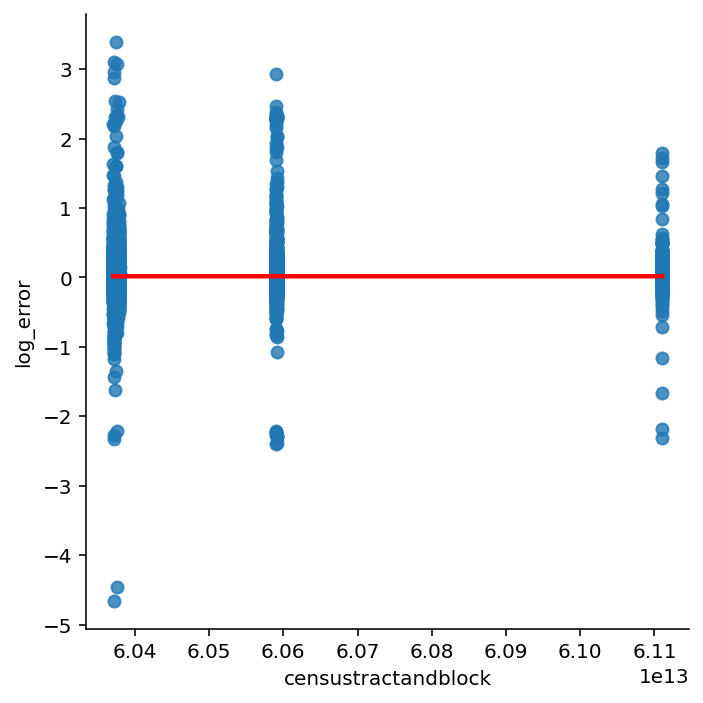

In [12]:
sns.lmplot(x='censustractandblock', y='log_error', data=train, line_kws={'color': 'red'})
plt.show()

Text(0.5, 1.0, 'Features Correlating with Census Neighborhood')

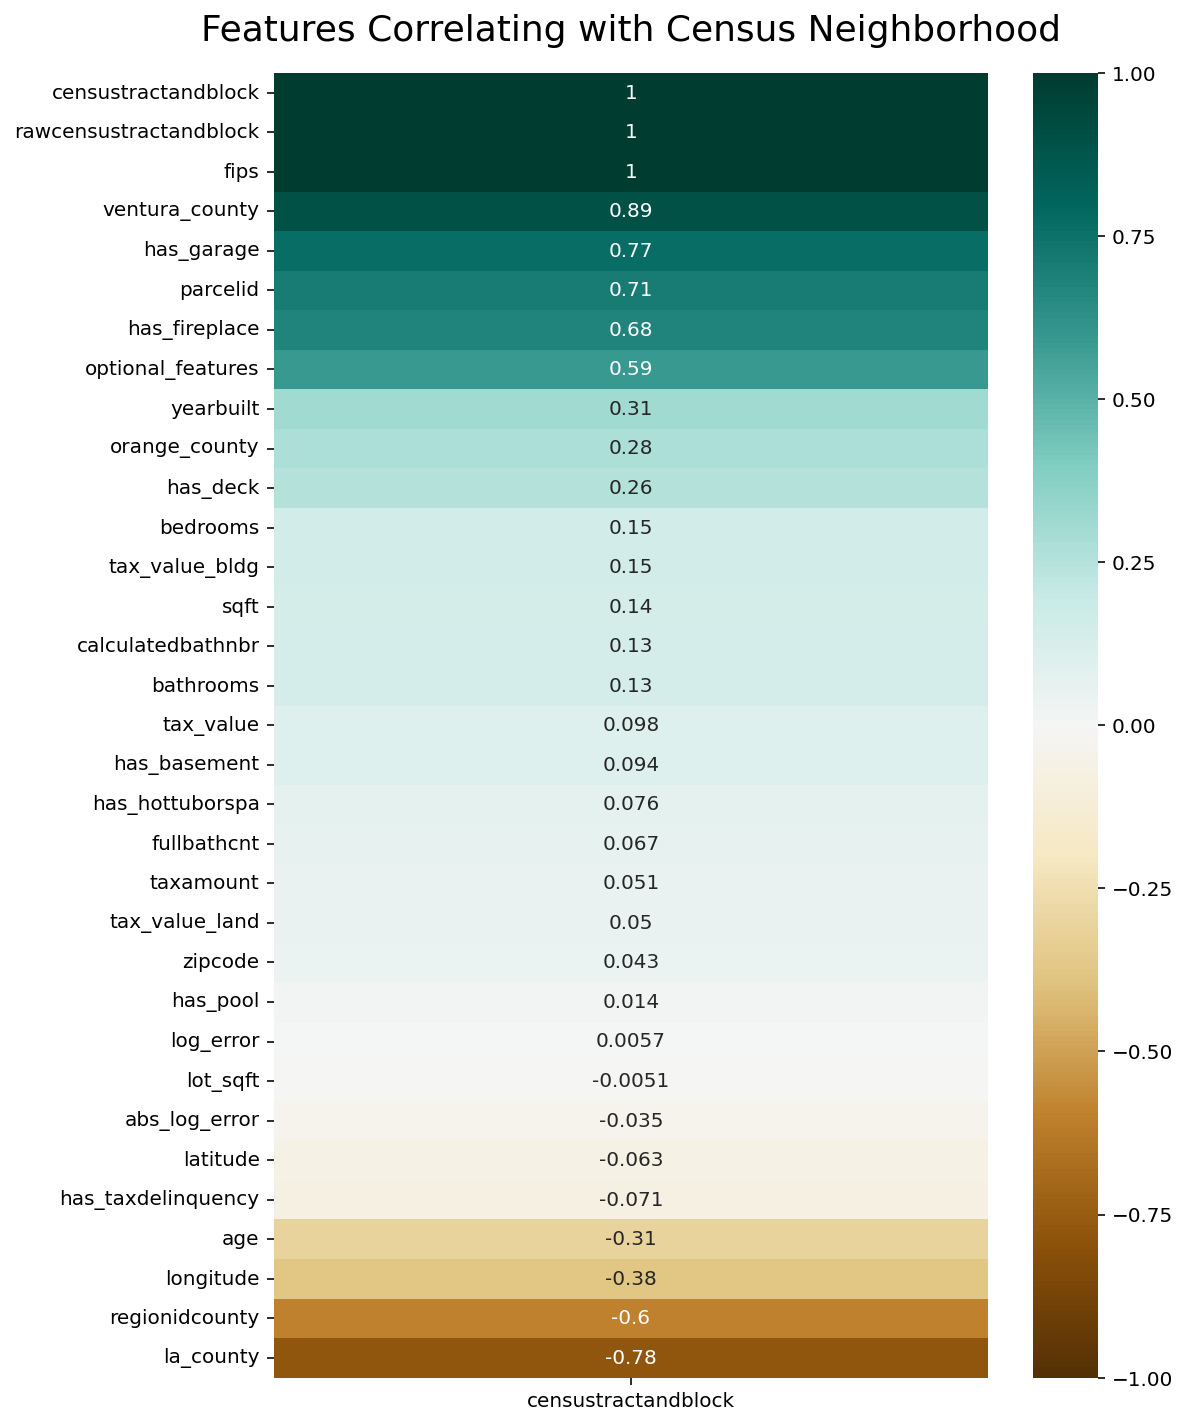

In [13]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='pearson')[['censustractandblock']].sort_values(by='censustractandblock', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Census Neighborhood', fontdict={'fontsize':18}, pad=16)

## Test Hypothesis

<div class="alert alert-warning">



# Pearson's R
**Compute test statistic and probability (r & p_value)**

In [ ]:
r, p_val = stats.pearsonr(train.censustractandblock,
                      train.log_error)
r, p_val

In [ ]:
if p_val < α:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

<div class="alert alert-info">
    
    
The Census Neighborhood has a ```significant Relationhip``` with our target log_error

<div class="alert alert-warning">


## Scale

In [ ]:
columns_to_scale = ['sqft',
                    'lot_sqft', 
                    'tax_value_bldg',
                    'tax_value', 
                    'tax_value_land']
scaler = MinMaxScaler()

train_scaled, validate_scaled, test_scaled = w.scale_data(train,
                                                           X_validate, 
                                                           X_test, 
                                                           columns_to_scale,
                                                           scaler,
                                                           return_scaler = False)

<div class="alert alert-warning">


## Cluster

In [ ]:
cluster_features = train_scaled[['sqft',
                                  'lot_sqft', 
                                  'tax_value_bldg',
                                  'tax_value', 
                                  'tax_value_land'
                                  ]]

In [ ]:
# Create it
kmeans = KMeans(n_clusters = 4)
# Fit it
kmeans.fit(cluster_features)
# Run it
kmeans.predict(cluster_features)

In [ ]:
train['has_features'] = kmeans.predict(cluster_features)

In [ ]:
train.has_features.value_counts()

In [ ]:
#Plot my predictions
sns.relplot(x='county', y='log_error', hue='has_features',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.scatterplot(x='county', y='log_error', hue='has_features',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.barplot(x='county', y='log_error', hue='cluster_features',
            palette='colorblind', data = train)

In [ ]:
#Plot my predictions
sns.boxplot(x='county', y='log_error', hue='has_features',
            palette='colorblind', data = train)

<div class="alert alert-warning">


## Modeling

<div class="alert alert-danger">
    
    
## Modeling: 
At least 4 different models are created and their performance is compared. One model is the distinct combination of algorithm, hyperparameters, and features.
* Establish Baseline of logerror
* Establish Metric for Modeling (RMSE, R^2)
* Evaluation DataFrame
* Model Selection

# COLUMN MANAGEMENT


# REARANGE
df = df[['parcelid',
         'bedroomcnt',
         'bathroomcnt', 
         'calculatedbathnbr', 
         'fullbathcnt',
         'age', 
         'yearbuilt', 
         'basementsqft', 
         'decktypeid', 
         'fireplacecnt', 
         'garagecarcnt', 
         'hashottuborspa', 
         'poolcnt', 
         'optional_features', 
         'taxdelinquencyyear', 
         'fips',
         'state', 
         'name',
         'Los Angeles County', 
         'Orange County', 
         'Ventura County'
         'longitude', 
         'latitude',
         'regionidzip', 
         'regionidcounty', 
         'rawcensustractandblock', 
         'censustractandblock', 
         'calculatedfinishedsquarefeet',
         'lotsizesquarefeet', 
         'structuretaxvaluedollarcnt',
         'taxvaluedollarcnt', 
         'landtaxvaluedollarcnt',
         'taxamount', 
         'log_error',]]

## Continuous Categorical Counts
'parcelid', 
'bedroomcnt',
'bathroomcnt', 
'calculatedbathnbr', 
'fullbathcnt',
'age', 
'yearbuilt', 

## Categorical Binary
'basementsqft', 
'decktypeid', 
'fireplacecnt', 
'garagecarcnt', 
'hashottuborspa', 
'poolcnt', 
'taxdelinquencyyear', 
'optional_features', 

## Location
'fips',
'state', 
'name',
'Los Angeles County', 
'Orange County', 
'Ventura County'
'longitude', 
'latitude',
'regionidzip', 
'regionidcounty', 
'rawcensustractandblock', 
'censustractandblock', 

## Size
'calculatedfinishedsquarefeet',
'lotsizesquarefeet', 

## Value
'structuretaxvaluedollarcnt',
'taxvaluedollarcnt', 
'landtaxvaluedollarcnt',
'taxamount', 

## Target
'log_error',

# DROP
# These columns were dropped by not adding them into the rearrange assignment
'id', 
'garagetotalsqft', 
'poolsizesum',
'pooltypeid10', 
'pooltypeid2', 
'pooltypeid7',
'propertycountylandusecode', 
'propertylandusetypeid',
'roomcnt',
'finishedsquarefeet12',
'numberofstories', 
'assessmentyear', 
'transaction_date', 
'land_use', 

# RENAME
#### Rename Binary Categoricals
df.rename(columns = {'hashottuborspa': 'has_hottuborspa',
                     'taxdelinquencyyear': 'has_taxdelinquency', 
                     'basementsqft': 'has_basement', 
                     'poolcnt': 'has_pool', 
                     'decktypeid': 'has_deck'
                     'fireplacecnt': 'has_fireplace'
                     'garagecarcnt': 'has_garage'
                     'Las Angele County': 'las_angeles'
                     'Ventura County': 'ventura'
                     'Orange County': 'orange'}
          , inplace = True)

#### Rename  Human Readable
df.rename(columns = {'name': 'county'
                     'bedroomcnt': 'bedrooms'
                     'bathroomcnt': 'bathrooms'
                     'structuretaxvaluedollarcnt': 'tax_value_bldg'
                     'taxvaluedollarcnt': 'tax_value'
                     'landtaxvaluedollarcnt': 'tax_value_land'
                     'regionidzip': 'zipcode'
                     'lotsizesquarefeet': 'lot_sqft'
                     'calculatedfinishedsquarefeet': 'sqft'}
          , inplace = True)

# COPY PASTE CODE TO PLAY WITH



####################################### NULL VALUES ############################################
def null_counter(df):
    ''' null_counter takes in a dataframe anc calculates the percent and amount of null cells in each column and row
    returns a dataframe with the results'''
    # name of dataframe names
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    # create data frame
    new_df = pd.DataFrame(columns = new_columns)
   
    # for loop to calculate missing /percent by columns
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        # create data frame
        add_df = pd.DataFrame([{'name': col,
                               'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
       
        # concat and index by row by seting axis to 0   
        new_df = pd.concat([new_df, add_df], axis = 0)
        
    # sets the index name
    new_df.set_index('name', inplace = True)
    
    return new_df

def null_dropper(df,prop_required_column,prop_required_row):

    ''' null_dropper takes in a dataframe a percent of required columns and rows to keep columns.
    all columns and rows outside of the null threshold will be dropped
    returns a clean dataframe dropped nulls'''
    
    # this is a decimal = 1- decimal
    prop_null_column = 1-prop_required_column
    
    # for columns, check null percentage and drop if a certain proportion is null (set by definition)
    for col in list(df.columns):
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns = col, inplace = True)
    
    # for rows, drop if a certain proportion is null. (set by definition)
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis = 0, thresh=row_threshold, inplace = True)
    
    return df
